In [1]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import gc
import re
import cv2
import sys
import glob
from glob import glob
import tensorflow as tf
import keras

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style  as style
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


from tqdm  import tqdm
from keras import backend
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from sklearn.metrics     import accuracy_score, roc_auc_score
from keras.layers        import Dense, Dropout, Flatten, BatchNormalization, GlobalMaxPooling2D
from keras.models        import Sequential, Model, load_model
from keras.callbacks     import ModelCheckpoint,ReduceLROnPlateau, CSVLogger
from keras.activations   import elu
from tensorflow.keras.layers import Layer, InputSpec

from keras.applications  import MobileNetV2
from keras.optimizers    import Adam
from keras.preprocessing import image
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Compose filenames
filelist_mt = glob(os.path.join('..', 'input', 'pulmonary-chest-xray-abnormalities','Montgomery','Montgomeryset','CXR_png' , '*.png'))
filelist_shenzen = glob(os.path.join('..', 'input', 'pulmonary-chest-xray-abnormalities','ChinaSet_AllFiles','ChinaSet_AllFiles','CXR_png' , '*.png'))
filelist= filelist_mt + filelist_shenzen

In [3]:
j = 0
for i in filelist:
    print(i)
    if j == 5:
        break
    j+=1

../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0092_0.png
../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0322_0.png
../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0304_0.png
../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0572_1.png
../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0547_1.png
../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0629_1.png


In [4]:
def extract_label(file_list):
    '''
    Label Extraction Function
    Reads a filename and extracts label from it
    '''
    labels = []
    for file in tqdm(file_list):
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
#         print(current_label)
        labels.append(current_label[0])
    return(labels)

In [5]:
label = extract_label(filelist)

100%|██████████| 662/662 [00:00<00:00, 170167.88it/s]


In [6]:
len(label)

662

In [7]:
df = pd.DataFrame(filelist, columns = ['Path'])
df['Label'] = label

y = df['Label']
X = df.drop(['Label'], axis = 1)
X.shape, y.shape

((662, 1), (662,))

In [8]:
#80% Training 20% Testing
df_train, X_test, label_train, y_test = train_test_split(X,
                                                         y,
                                                         stratify = y,
                                                         random_state = 19,
                                                         test_size = 0.2)
# 80% Training 20% Validation
X_train, X_valid, y_train, y_valid = train_test_split(df_train,
                                                     label_train,
                                                     stratify = label_train,
                                                     random_state = 19,
                                                     test_size = 0.2)
print('Train size')
print(X_train.shape, y_train.shape)
print('Validation Size')
print(X_valid.shape, y_valid.shape)
print('Testing Size')
print(X_test.shape, y_test.shape)

Train size
(423, 1) (423,)
Validation Size
(106, 1) (106,)
Testing Size
(133, 1) (133,)


In [9]:
train_df = X_train.copy()
train_df['Label'] = y_train


#Valid
valid_df = X_valid.copy()
valid_df['Label'] = y_valid


#Test
test_df = X_test.copy()
test_df['Label'] = y_test
train_df.head()

,Path,Label
587,../input/pulmonary-chest-xray-abnormalities/Ch...,1
30,../input/pulmonary-chest-xray-abnormalities/Ch...,1
126,../input/pulmonary-chest-xray-abnormalities/Ch...,1
182,../input/pulmonary-chest-xray-abnormalities/Ch...,1
346,../input/pulmonary-chest-xray-abnormalities/Ch...,0


In [10]:
print("Train Value Counts")
print(train_df['Label'].value_counts())
print("Validation DF Value Counts")
print(valid_df['Label'].value_counts())
print("Test DF Value Counts")
print(test_df['Label'].value_counts())

Train Value Counts
Label
1    214
0    209
Name: count, dtype: int64
Validation DF Value Counts
Label
1    54
0    52
Name: count, dtype: int64
Test DF Value Counts
Label
1    68
0    65
Name: count, dtype: int64


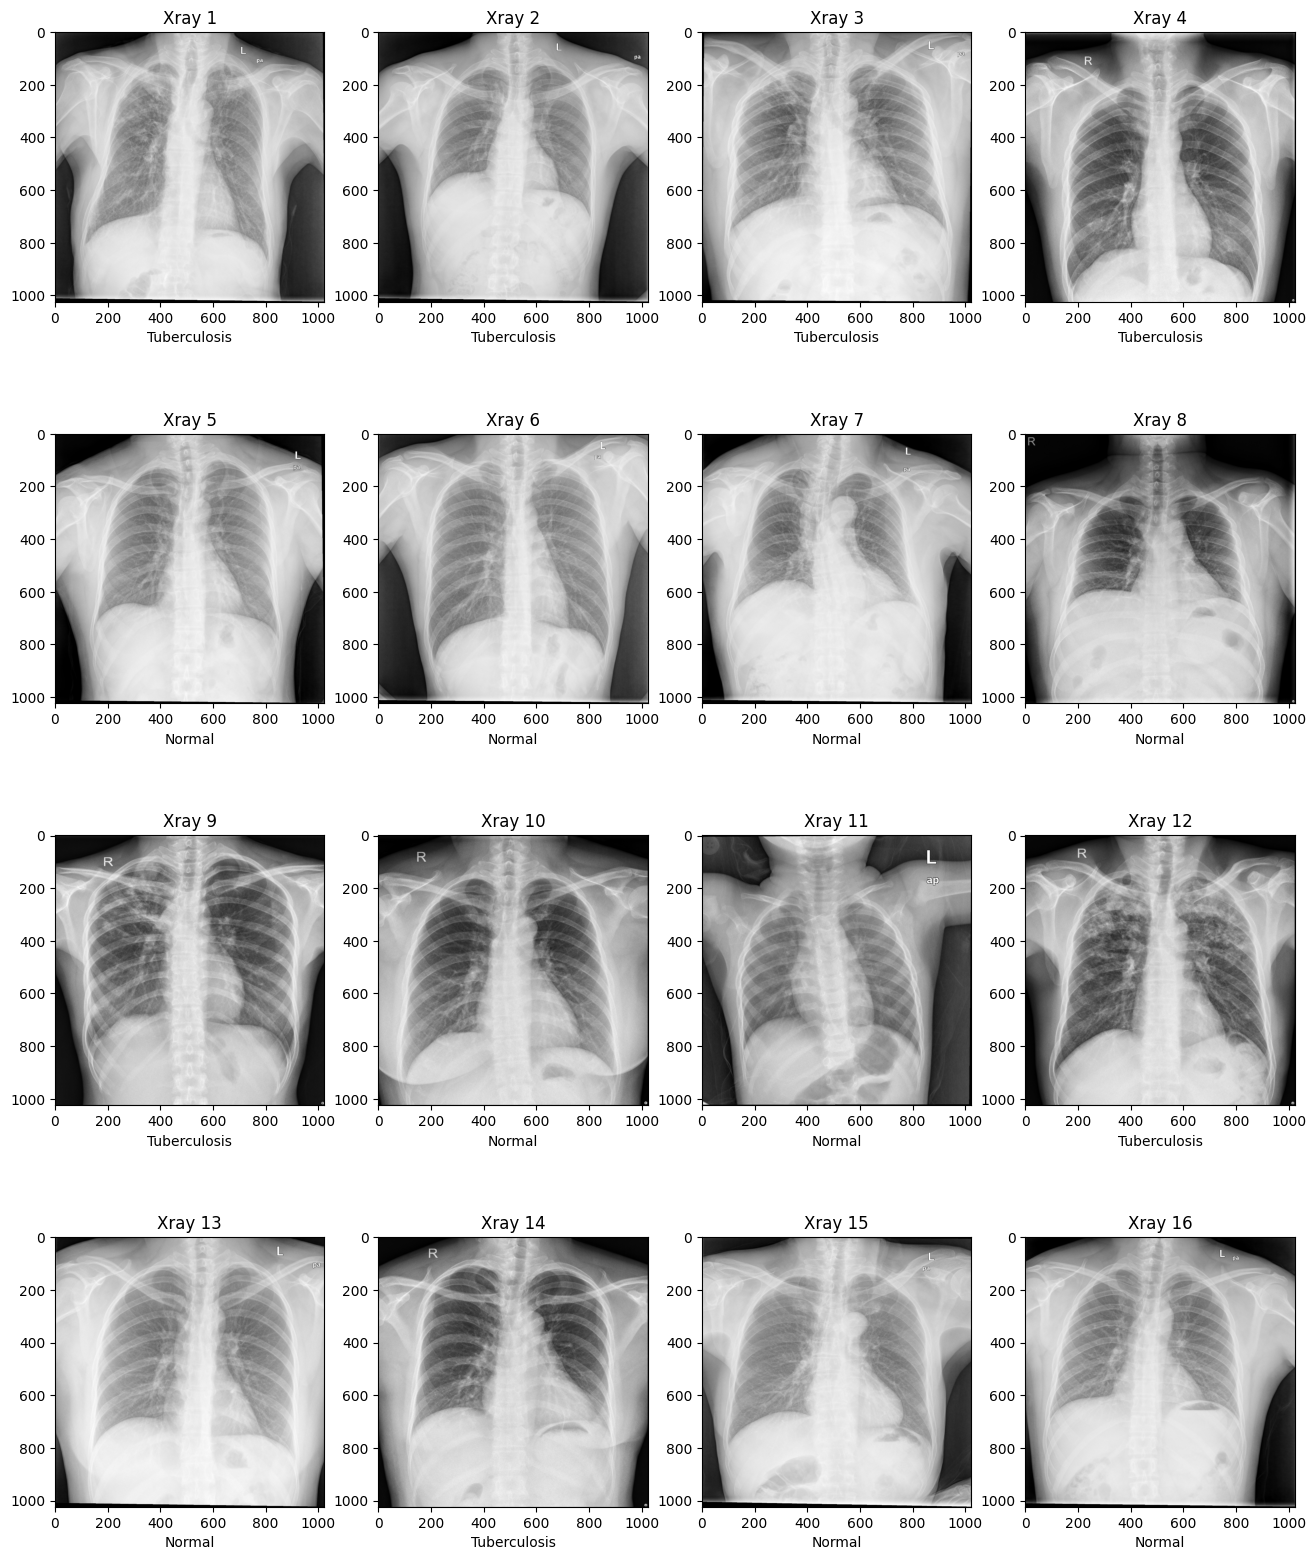

In [11]:
def plot_multiple_images(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(1024,1024), preprocessing=None):

    image_dataframe = image_dataframe.reset_index(drop=True)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
#     print(image_dataframe)
    i = 1
    for j in range(rows):
        for k in range(columns):
            img = plt.imread(image_dataframe.loc[i-1,'Path'])
            img = cv2.resize(img, resize)
            if preprocessing:
                img = preprocessing(img)
            ax[j][k].set_title("Xray "+str(i))
            a = image_dataframe.loc[i-1, 'Label']
            if int(a) == 0:
                ax[j][k].set_xlabel('Normal')
            else:
                ax[j][k].set_xlabel('Tuberculosis')  
                
            ax[j][k].imshow(img, alpha=1, cmap='gray')
            i+=1
            
        if(i == (rows*columns)):
            break
    plt.show()
#Plotting Train images
plot_multiple_images(train_df)

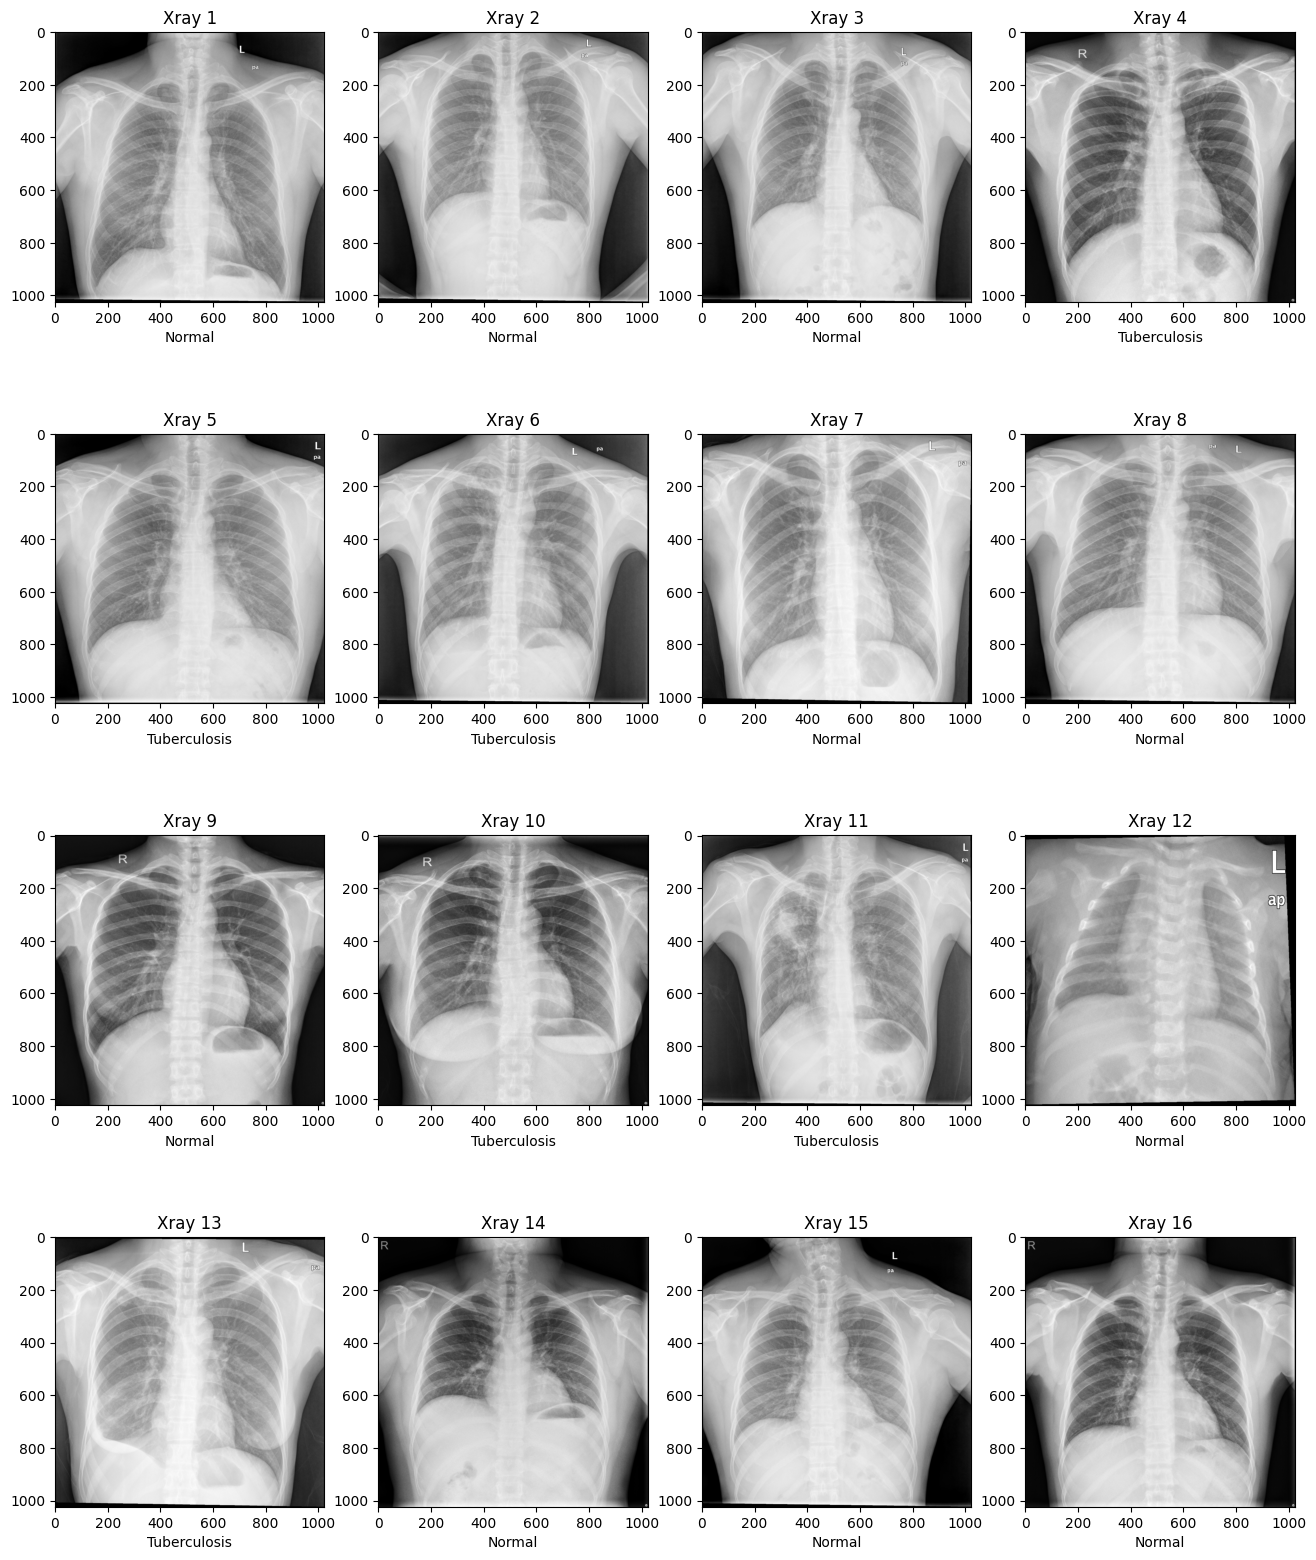

In [12]:
#Plotting Test Images
plot_multiple_images(valid_df)

In [13]:
BATCH = 32
IMAGE_INPUT = (224, 224)
def cal_steps(num_images, batch_size):
    steps = num_images // batch_size

    return steps + 1 if (steps * batch_size) < num_images else steps
tf.random.set_seed(19)
train_generator = ImageDataGenerator(rescale = 1./255,)

test_generator  = ImageDataGenerator(rescale = 1./255,)

In [14]:
#Training Data
train_aug_generator = ImageDataGenerator(rescale = 1./255,
                                     zoom_range      = 0.05,
                                     shear_range     = 0,
                                     width_shift_range  = 0.05,
                                     height_shift_range = 0.05,
                                     )
train = train_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = True,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)

train_aug = train_aug_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = True,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)
#Validation Data
valid = train_generator.flow_from_dataframe(dataframe = valid_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = True,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)
valid2 = train_generator.flow_from_dataframe(dataframe = valid_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = False,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)
#Testing Data
test = test_generator.flow_from_dataframe(dataframe = test_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = False,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT)

Found 423 validated image filenames belonging to 2 classes.
Found 423 validated image filenames belonging to 2 classes.
Found 106 validated image filenames belonging to 2 classes.
Found 106 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.


In [15]:
def plot_training_hist(keras_model):
    '''
    Plot training History
    Creates two plots of model training logs
    '''
    hist = keras_model.history
    style.use('fivethirtyeight')
    
    # Loss Plot
    fig = plt.figure(figsize=(8,3))
    plt.title('Loss Plot')
    plt.plot(hist['loss'], '#07e9ed')
    plt.plot(hist['val_loss'], '#0791ed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0,1.2 * max(max(hist['loss'], hist['val_loss']))])
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
    # Accuracy Plot
    fig = plt.figure(figsize=(8,3))
    plt.title('Accuracy Plot')
    plt.plot(hist['accuracy'], '#07e9ed')
    plt.plot(hist['val_accuracy'], '#0791ed')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')    
    plt.legend(['train', 'validation'], loc='lower right')
    plt.ylim([0,1])
    
    #ROC Plot
    fig = plt.figure(figsize=(8,3))
    plt.title('Recall Plot')
    plt.plot(hist['recall'], '#07e9ed')
    plt.plot(hist['val_recall'], '#0791ed')
    plt.xlabel('Epochs')
    plt.ylabel('Recall Score')    
    plt.legend(['train', 'validation'], loc='lower right')
    plt.ylim([0,1])
    # Show Plot, reset style
    plt.show()
    style.use('default')

In [16]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs): 
        print("val / train : {:.2f}".format(logs['val_loss']/logs['loss']))
    
checkpoint_cb = keras.callbacks.ModelCheckpoint("baseline_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 
callbacks = [checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]
#Defining Metrics


In [17]:
import keras
from keras import backend as K

def true_positive_rate(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def dice_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))

# model 1

In [18]:
# Making Resnet Model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
resnet50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
feature_extractor_layer = hub.KerasLayer(resnet50_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_INPUT+(3,)) # define the input image shap


resnet_model = keras.Sequential([
    feature_extractor_layer,
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation = 'sigmoid'),
])

resnet_model.compile(
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(),
        'accuracy',
        keras.metrics.MeanAbsoluteError(),
        keras.metrics.MeanSquaredError(),
        dice_coef,
        keras.metrics.MeanIoU(num_classes=2),  # Change num_classes as required
        precision,
        recall,
        f1_score,
        true_positive_rate
    ],
    optimizer=keras.optimizers.Adam(learning_rate=5e-4)
)
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23575041 (89.93 MB)
Trainable params: 6145 (24.00 KB)
Non-trainable params: 23568896 (89.91 MB)
_________________________________________________________________


In [19]:
resnet_history = resnet_model.fit(train_aug,
                                 validation_data = valid,
                                 steps_per_epoch =len(train_aug),
                                 validation_steps =  len(valid),
                                 epochs = 50,
                                 callbacks = [callbacks])

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 0.9396 - binary_accuracy: 0.4421 - accuracy: 0.4421 - mean_absolute_error: 0.5268 - mean_squared_error: 0.3370 - dice_coef: 0.4682 - mean_io_u: 0.2470 - precision: 0.4493 - recall: 0.4219 - f1_score: 0.4297 - true_positive_rate: 0.4219

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


val / train : 0.81
14/14 [==============================] - 80s 5s/step - loss: 0.9396 - binary_accuracy: 0.4421 - accuracy: 0.4421 - mean_absolute_error: 0.5268 - mean_squared_error: 0.3370 - dice_coef: 0.4682 - mean_io_u: 0.2470 - precision: 0.4493 - recall: 0.4219 - f1_score: 0.4297 - true_positive_rate: 0.4219 - val_loss: 0.7613 - val_binary_accuracy: 0.5283 - val_accuracy: 0.5283 - val_mean_absolute_error: 0.4866 - val_mean_squared_error: 0.2762 - val_dice_coef: 0.5575 - val_mean_io_u: 0.2453 - val_precision: 0.5092 - val_recall: 0.9175 - val_f1_score: 0.6411 - val_true_positive_rate: 0.9175
Epoch 2/50
14/14 [==============================] - 51s 4s/step - loss: 0.6954 - binary_accuracy: 0.6147 - accuracy: 0.6147 - mean_absolute_error: 0.4294 - mean_squared_error: 0.2406 - dice_coef: 0.5596 - mean_io_u: 0.2470 - precision: 0.6070 - recall: 0.5835 - f1_score: 0.5889 - true_positive_rate: 0.5835 - val_loss: 0.6308 - val_binary_accuracy: 0.6698 - val_accuracy: 0.6698 - val_mean_absol

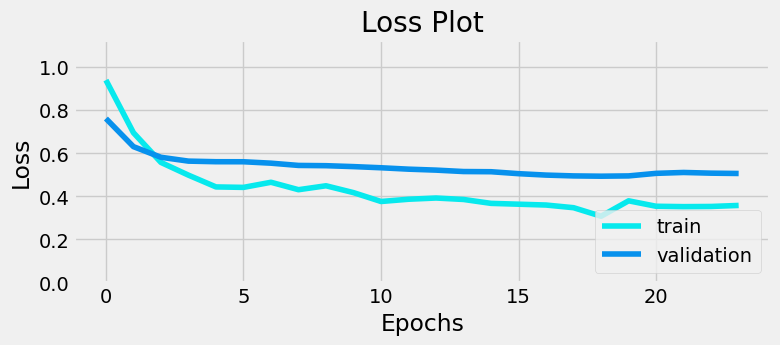

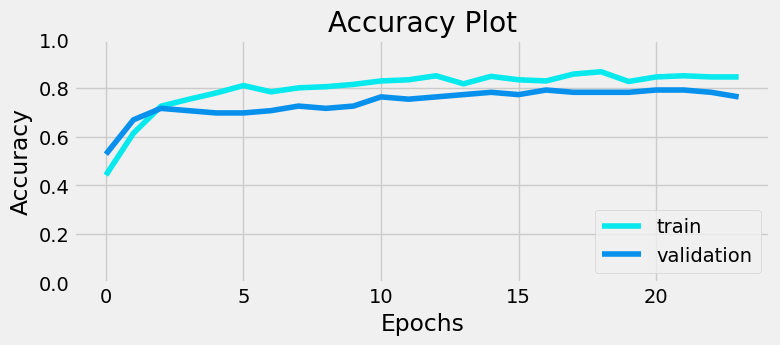

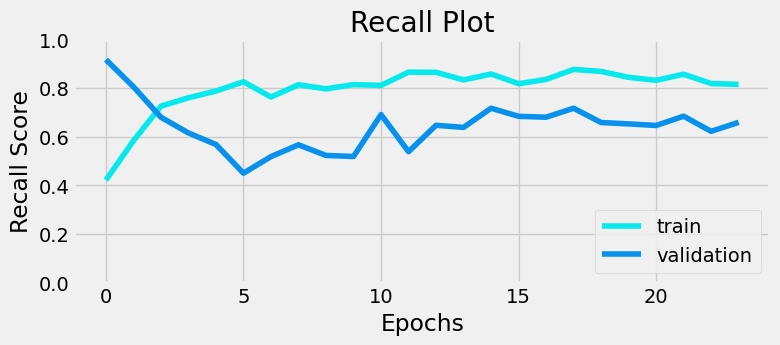

In [20]:
plot_training_hist(resnet_history)

In [21]:
training_accuracy = resnet_history.history['accuracy']
validation_accuracy = resnet_history.history['val_accuracy']

In [22]:
print('average training accuracy : ', np.mean(np.array(training_accuracy)))
print('average validating accuracy : ', np.mean(np.array(validation_accuracy)))

average training accuracy :  0.7968873158097267
average validating accuracy :  0.7409591178099314


In [23]:
evaluation_results = resnet_model.evaluate(test)
metrics_names = resnet_model.metrics_names
print("Metrics names:", metrics_names)
print("Additional metrics on test dataset:",evaluation_results )

5/5 [==============================] - 17s 4s/step - loss: 0.4059 - binary_accuracy: 0.8045 - accuracy: 0.8045 - mean_absolute_error: 0.2764 - mean_squared_error: 0.1301 - dice_coef: 0.6973 - mean_io_u: 0.2444 - precision: 0.8716 - recall: 0.7154 - f1_score: 0.7697 - true_positive_rate: 0.7154
Metrics names: ['loss', 'binary_accuracy', 'accuracy', 'mean_absolute_error', 'mean_squared_error', 'dice_coef', 'mean_io_u', 'precision', 'recall', 'f1_score', 'true_positive_rate']
Additional metrics on test dataset: [0.4059077799320221, 0.8045112490653992, 0.8045112490653992, 0.2764405906200409, 0.130060613155365, 0.6972572803497314, 0.24436090886592865, 0.8715685606002808, 0.7153571248054504, 0.769676148891449, 0.7153571248054504]


In [24]:
print("Loss:",evaluation_results[0])
print("Binary Accuracy:", evaluation_results[1])
print('average testing accuracy : ', evaluation_results[2])
print("MAE:", evaluation_results[3])
print("MSE:", evaluation_results[4])
print("Dice Coefficient:",evaluation_results[5])
print("Mean IoU:", evaluation_results[6])
print("Precision:", evaluation_results[7])
print("Recall:", evaluation_results[8])
print("F1 Score:", evaluation_results[9])
print("True Positive Rate:", evaluation_results[10])

Loss: 0.4059077799320221
Binary Accuracy: 0.8045112490653992
average testing accuracy :  0.8045112490653992
MAE: 0.2764405906200409
MSE: 0.130060613155365
Dice Coefficient: 0.6972572803497314
Mean IoU: 0.24436090886592865
Precision: 0.8715685606002808
Recall: 0.7153571248054504
F1 Score: 0.769676148891449
True Positive Rate: 0.7153571248054504


 ## Resnet 2
 add more dense layers and change the activation function of the layers

In [25]:
from keras.metrics import MeanIoU

In [26]:
# Making Resnet Model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
resnet50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
feature_extractor_layer = hub.KerasLayer(resnet50_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_INPUT+(3,)) # define the input image shap

resnet_model2 = keras.Sequential([
    feature_extractor_layer,
    keras.layers.BatchNormalization(),
    keras.layers.Dense(80, activation = 'elu', kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(80, activation = 'elu', kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation = 'sigmoid'),
])

resnet_model2.compile(
    loss='binary_crossentropy',
    metrics=[
        'binary_accuracy',
        'accuracy',
        'mean_absolute_error',
        'mean_squared_error',
        MeanIoU(num_classes=2),
        dice_coef,
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.F1Score(),
        keras.metrics.TruePositives()
        
    ],
    optimizer=keras.optimizers.Adam(learning_rate=5e-4)
)

In [27]:
resnet_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 80)                163920    
                                                                 
 batch_normalization_1 (Bat  (None, 80)                320       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                        

In [28]:
feature_extractor_layer.output_shape

(None, 2048)

In [29]:
resnet_history2 = resnet_model2.fit(train_aug,
                                 validation_data = valid,
                                steps_per_epoch = len(train_aug),
                                 validation_steps =  len(valid),
                                 epochs = 25,
                                 callbacks = [callbacks])

Epoch 1/25
14/14 [==============================] - ETA: 0s - loss: 0.7407 - binary_accuracy: 0.6548 - accuracy: 0.6548 - mean_absolute_error: 0.3808 - mean_squared_error: 0.2406 - mean_io_u: 0.2470 - dice_coef: 0.6145 - precision: 0.6574 - recall: 0.6636 - f1_score: 0.6719 - true_positives: 142.0000

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


val / train : 1.62
14/14 [==============================] - 61s 4s/step - loss: 0.7407 - binary_accuracy: 0.6548 - accuracy: 0.6548 - mean_absolute_error: 0.3808 - mean_squared_error: 0.2406 - mean_io_u: 0.2470 - dice_coef: 0.6145 - precision: 0.6574 - recall: 0.6636 - f1_score: 0.6719 - true_positives: 142.0000 - val_loss: 1.2031 - val_binary_accuracy: 0.5000 - val_accuracy: 0.5000 - val_mean_absolute_error: 0.4594 - val_mean_squared_error: 0.3815 - val_mean_io_u: 0.2453 - val_dice_coef: 0.2529 - val_precision: 1.0000 - val_recall: 0.0185 - val_f1_score: 0.6750 - val_true_positives: 1.0000
Epoch 2/25
14/14 [==============================] - 50s 4s/step - loss: 0.4830 - binary_accuracy: 0.8014 - accuracy: 0.8014 - mean_absolute_error: 0.2644 - mean_squared_error: 0.1458 - mean_io_u: 0.2470 - dice_coef: 0.7370 - precision: 0.8095 - recall: 0.7944 - f1_score: 0.6719 - true_positives: 170.0000 - val_loss: 1.1818 - val_binary_accuracy: 0.5283 - val_accuracy: 0.5283 - val_mean_absolute_erro

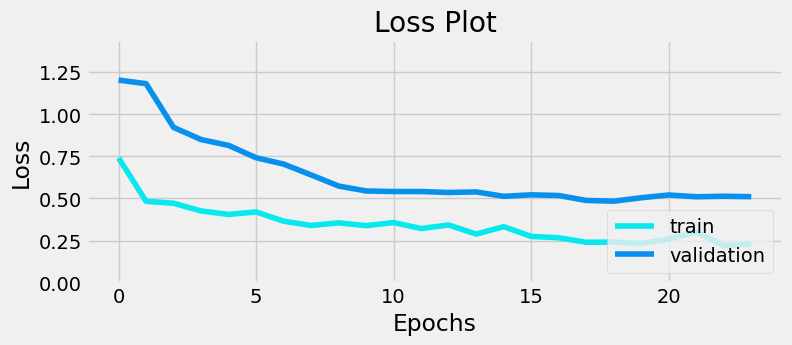

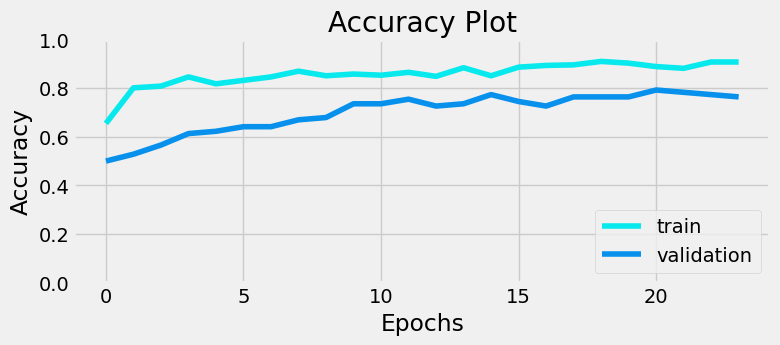

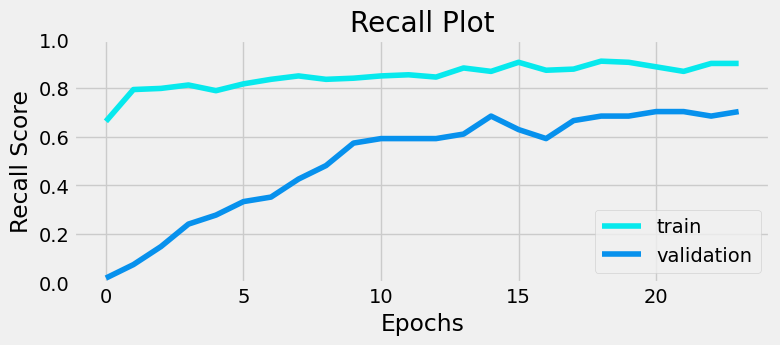

In [30]:
plot_training_hist(resnet_history2)

In [31]:
training_accuracy2 = resnet_history2.history['accuracy']
validation_accuracy2 = resnet_history2.history['val_accuracy']


In [32]:
print('average training accuracy : ', np.mean(np.array(training_accuracy2)))
print('average validating accuracy : ', np.mean(np.array(validation_accuracy2)))

average training accuracy :  0.8568754891554514
average validating accuracy :  0.7000786115725836


In [33]:
evaluation_results2 = resnet_model2.evaluate(test)
metrics_names2 = resnet_model2.metrics_names
print("Metrics names:", metrics_names2)
print("Additional metrics on test dataset:",evaluation_results2 )


5/5 [==============================] - 11s 2s/step - loss: 0.4283 - binary_accuracy: 0.8421 - accuracy: 0.8421 - mean_absolute_error: 0.2312 - mean_squared_error: 0.1285 - mean_io_u: 0.2444 - dice_coef: 0.7327 - precision: 0.8615 - recall: 0.8235 - f1_score: 0.6766 - true_positives: 56.0000
Metrics names: ['loss', 'binary_accuracy', 'accuracy', 'mean_absolute_error', 'mean_squared_error', 'mean_io_u', 'dice_coef', 'precision', 'recall', 'f1_score', 'true_positives']
Additional metrics on test dataset: [0.4282990097999573, 0.8421052694320679, 0.8421052694320679, 0.2312498688697815, 0.12849417328834534, 0.24436090886592865, 0.7326511740684509, 0.8615384697914124, 0.8235294222831726, array([0.67661697], dtype=float32), 56.0]


In [34]:
print("Loss:",evaluation_results2[0])
print("Binary Accuracy:", evaluation_results2[1])
print('average testing accuracy : ', evaluation_results2[2])
print("MAE:", evaluation_results2[3])
print("MSE:", evaluation_results2[4])
print("Dice Coefficient:",evaluation_results2[5])
print("Mean IoU:", evaluation_results2[6])
print("Precision:", evaluation_results2[7])
print("Recall:", evaluation_results2[8])
print("F1 Score:", evaluation_results2[9])
print("True Positive Rate:", evaluation_results2[10])

Loss: 0.4282990097999573
Binary Accuracy: 0.8421052694320679
average testing accuracy :  0.8421052694320679
MAE: 0.2312498688697815
MSE: 0.12849417328834534
Dice Coefficient: 0.24436090886592865
Mean IoU: 0.7326511740684509
Precision: 0.8615384697914124
Recall: 0.8235294222831726
F1 Score: [0.67661697]
True Positive Rate: 56.0
